## feature ranking with elimination

In [1]:
import csv
import time  # Just to compare fit times
from pathlib import Path
from pprint import pprint
import csv
import multiprocessing

In [1]:
import numpy as np
# import xgboost as xgb
# from matplotlib import pyplot as plt
from sklearn import metrics
# from sklearn.model_selection import train_test_split
import dask.dataframe as dd
import xgboost as xgb
# from tune_sklearn import TuneSearchCV
# from xgboost import XGBRegressor
# import xgboost as xgb


In [4]:
input_dataset_path = Path('../data/input_dataset_filtered.csv')

In [5]:
%%time

# read the csv file created
train = np.genfromtxt(input_dataset_path, delimiter=',',skip_header=1)


X, y = train[:, 1:], train[:, :1]
y = y.ravel()

# Set training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

CPU times: user 15.4 s, sys: 871 ms, total: 16.2 s
Wall time: 16.2 s


In [6]:
headers = next(csv.reader(open(input_dataset_path)))
print(len(headers),headers[0])

45 target


## Build-in Recursive feature elimination with cross-validation


Optimal number of features : 35


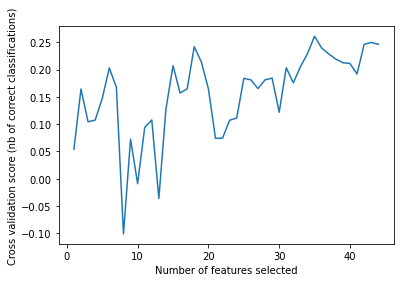

CPU times: user 10min 20s, sys: 12.5 s, total: 10min 33s
Wall time: 2min 43s


In [9]:
%%time
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist'
)

# The "accuracy" scoring is proportional to the number of correct
# classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=xgb_model, cv=3, scoring='r2')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)


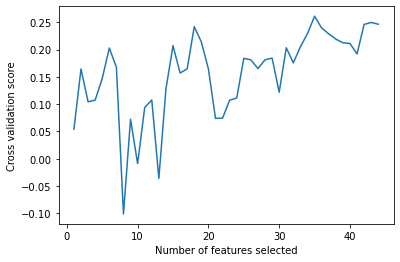

In [13]:

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_)
plt.show()

In [14]:
rfecv.support_

array([ True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

array([ 1,  1,  1,  1,  1,  1,  5,  8,  1,  1,  1,  4,  3,  1,  9,  1,  1,
        1,  1,  1,  7,  1,  1,  1,  1,  1,  1,  6,  1,  1, 10,  1,  1,  1,
        2,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [16]:
headers = next(csv.reader(open(input_dataset_path)))[1:]

unsorteddic = {}
for i, rank in enumerate(rfecv.ranking_):
        unsorteddic[headers[i]] = rank
sorteddic = dict(sorted(unsorteddic.items(), key=lambda item: item[1]))
sorteddic

{'/g/data/ge3/sheece/LOC_distance_to_coast.tif': 1,
 '/g/data/ge3/sheece/mrvbf_9.tif': 1,
 '/g/data/ge3/sheece/relief_mrvbf_3s_mosaic.tif': 1,
 '/g/data/ge3/sheece/relief_elev_focalrange1000m_3s.tif': 1,
 '/g/data/ge3/sheece/relief_elev_focalrange300m_3s.tif': 1,
 '/g/data/ge3/sheece/saga_wetSM_85_resampled.tif': 1,
 '/g/data/ge3/sheece/dem_fill.tif': 1,
 '/g/data/ge3/sheece/3dem_mag2.tif': 1,
 '/g/data/ge3/sheece/3dem_mag1_fin.tif': 1,
 '/g/data/ge3/sheece/Dose_2016.tif': 1,
 '/g/data/ge3/sheece/Potassium_2016.tif': 1,
 '/g/data/ge3/sheece/Thorium_2016.tif': 1,
 '/g/data/ge3/sheece/Rad2016U_Th.tif': 1,
 '/g/data/ge3/sheece/Rad2016K_Th.tif': 1,
 '/g/data/ge3/sheece/si_geol1.tif': 1,
 '/g/data/ge3/sheece/ceno_euc_aust1.tif': 1,
 '/g/data/ge3/sheece/Grav_lane_clip.tif': 1,
 '/g/data/ge3/sheece/be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata.tif': 1,
 '/g/data/ge3/sheece/be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata.tif': 1,
 '/g/data/ge3/sheece/be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.noda

## In-house Recursive feature elimination

In [33]:
import csv
import time  # Just to compare fit times
from pathlib import Path
from pprint import pprint
import csv
import multiprocessing
import pandas as pd
import numpy as np
import distributed

import dask
import dask.array as da
import dask.dataframe as dd
from dask.distributed import Client, wait, LocalCluster

from dask_cuda import LocalCUDACluster
from sklearn.model_selection import train_test_split

# from dask_ml.model_selection import train_test_split
from sklearn.metrics import r2_score
from dask_ml.metrics import r2_score
import xgboost as xgb
import statistics

# from sklearn.metrics import  explained_variance_score, mean_absolute_error, mean_squared_error, r2_score



In [83]:
# Start cluster and client. This is currently local, although I would like to make this distributed across many nodes.
# cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES='0,1,2,3', threads_per_worker=2)
cluster = LocalCluster(n_workers=90,threads_per_worker=2,dashboard_address='0.0.0.0:8787')
# cluster = LocalCluster(dashboard_address='0.0.0.0:8787') # Workers: 6, Cores: 24
# cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES='0,1,2,3', threads_per_worker=24,dashboard_address='0.0.0.0:8787')

# cluster = LocalCUDACluster()
client = Client(cluster)
client

/home/547/sg4953/uncoverml/venv/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41689 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:37071 Dashboard: http://127.0.0.1:41689/status,Cluster Workers: 90 Cores: 180 Memory: 202.48 GB


In [139]:
@dask.delayed
def get_score_without_feature(features_to_drop):
    
    features_to_drop = ["target"]

    input_dataset_path = Path('/g/data/ge3/sheece/input_dataset.csv')

    pdf = pd.read_csv(input_dataset_path) 
    dtrain = dask.delayed(xgb.DMatrix)(data=pdf.drop(features_to_drop,axis=1), label=pdf["target"],nthread=-1)

    param = {
        'objective':'reg:squarederror',
        'tree_method':'approx',
        'predictor': 'cpu_predictor'
    }
    evaluation_history = dask.delayed(xgb.cv)(param, dtrain,nfold=3,metrics="rmsle",verbose_eval=False,seed=0)

    return dask.delayed(statistics.mean)(evaluation_history.iloc[:]['train-rmse-mean'])
    
    

In [125]:
features = ['LOC_distance_to_coast','mrvbf_9','relief_mrvbf_3s_mosaic','relief_elev_focalrange1000m_3s','relief_elev_focalrange300m_3s','saga_wetSM_85_resampled','tpi_300','slope_fill2','dem_fill','3dem_mag2','3dem_mag1_fin','3dem_mag0.fin','relief_roughness','LATITUDE_GRID1_clip','Dose_2016','Potassium_2016','Thorium_2016','Rad2016U_Th','Rad2016K_Th','national_Wii_RF_multirandomforest_prediction','si_geol1','ceno_euc_aust1','Grav_lane_clip','be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata','be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata','be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata','be-30y-85m-avg_BLUE+SWIR2','be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata','be-30y-85m-avg-CLAY-PC2.filled.lzw.nodata','be-30y-85m-avg-RED.filled.lzw.nodata','be-30y-85m-avg-GREEN.filled.lzw.nodata','be-l8-all-85m-avg-BLUE.filled.lzw.nodata','be-l8-all-85m-avg-NIR.filled.lzw.nodata','be-30y-85m-avg-SWIR1.filled.lzw.nodata','be-30y-85m-avg-SWIR2.filled.lzw.nodata','s2-dpca-85m','water-85m','clim_EPA_albers','Clim_Prescott_LindaGregory','clim_PTA_albers','clim_WDA_albers','clim_RSM_albers']

' LOC_distance_to_coast ' ,
' mrvbf_9 ' ,
' relief_mrvbf_3s_mosaic ' ,
' relief_elev_focalrange1000m_3s ' ,
' relief_elev_focalrange300m_3s ' ,
' saga_wetSM_85_resampled ' ,
' tpi_300 ' ,
' slope_fill2 ' ,
' dem_fill ' ,
' 3dem_mag2 ' ,
' 3dem_mag1_fin ' ,
' 3dem_mag0.fin ' ,
' relief_roughness ' ,
' LATITUDE_GRID1_clip ' ,
' Dose_2016 ' ,
' Potassium_2016 ' ,
' Thorium_2016 ' ,
' Rad2016U_Th ' ,
' Rad2016K_Th ' ,
' national_Wii_RF_multirandomforest_prediction ' ,
' si_geol1 ' ,
' ceno_euc_aust1 ' ,
' Grav_lane_clip ' ,
' be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata ' ,
' be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata ' ,
' be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata ' ,
' be-30y-85m-avg_BLUE+SWIR2 ' ,
' be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata ' ,
' be-30y-85m-avg-CLAY-PC2.filled.lzw.nodata ' ,
' be-30y-85m-avg-RED.filled.lzw.nodata ' ,
' be-30y-85m-avg-GREEN.filled.lzw.nodata ' ,
' be-l8-all-85m-avg-BLUE.filled.lzw.nodata ' ,
' be-l8-all-85m-avg-NIR.filled.lzw.nodata ' ,
' be

In [134]:
def min_feature(scores):
    min_score = 999
    for score in scores:
        if score<min_score:
            min_score=score
    return min_score

In [136]:

scores = []
for feature in features:
    score = get_score_without_feature([feature])
    scores.append(score)
min_score = sum(scores)
final_result = min_score.compute()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distribu

KilledWorker: ('add-a0a83e59861773e2bda7f1726fab7264', <Worker 'tcp://127.0.0.1:42067', name: 29, memory: 0, processing: 1>)

In [127]:
results.visualize

AttributeError: 'list' object has no attribute 'visualize'

In [119]:
%%time

now = time.time()
results = []
for feature in next(csv.reader(open(input_dataset_path)))[1:]:
    score = get_score_without_feature([feature])
    results.append(score)
    

total = min(results)
final_result = total.compute()
after = time.time()
print(after-now)
print(result)

TypeError: Truth of Delayed objects is not supported

In [61]:
pdf.drop("target",axis=1)

,LOC_distance_to_coast,mrvbf_9,relief_mrvbf_3s_mosaic,relief_elev_focalrange1000m_3s,relief_elev_focalrange300m_3s,saga_wetSM_85_resampled,tpi_300,slope_fill2,dem_fill,3dem_mag2,...,be-l8-all-85m-avg-NIR.filled.lzw.nodata,be-30y-85m-avg-SWIR1.filled.lzw.nodata,be-30y-85m-avg-SWIR2.filled.lzw.nodata,s2-dpca-85m,water-85m,clim_EPA_albers,Clim_Prescott_LindaGregory,clim_PTA_albers,clim_WDA_albers,clim_RSM_albers
0,2.006358,1.0,4.0,21.217691,9.958379,10.004804,-0.264486,0.940742,205.45955,0.252660,...,0.2428,0.2789,0.1753,192.0,0.026451,1833.6868,0.486201,803.89575,-1029.7910,19.990330
1,2.025787,1.0,0.0,16.920124,8.870855,9.931655,0.076412,1.034455,213.70831,0.372421,...,0.2298,0.2535,0.1592,210.0,0.017286,1826.2247,0.485900,802.70060,-1023.5242,19.941477
2,2.024727,2.0,0.0,16.054580,8.281430,10.118466,0.634743,0.590773,215.25793,0.392912,...,0.2315,0.2410,0.1490,210.0,0.012877,1828.1902,0.486590,803.20340,-1024.9868,19.971191
3,2.014133,0.0,0.0,14.514371,4.592542,10.619378,0.401459,0.207132,213.89566,0.377955,...,0.2255,0.2558,0.1598,232.0,0.021657,1831.6632,0.486417,804.41610,-1027.2472,20.002070
4,0.288717,3.0,3.0,8.905590,2.398981,11.260143,0.033232,0.065560,49.18580,-0.787380,...,0.2091,0.2476,0.1597,70.0,0.078101,1880.6023,0.538680,820.63116,-1059.9712,19.701004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489312,2.970986,0.0,0.0,115.514275,53.343456,7.813678,-0.731629,2.604903,441.37753,0.416707,...,0.1618,0.3265,0.2620,254.0,0.004486,2084.2183,0.124384,264.62190,-1819.5963,22.838608
489313,2.970441,0.0,2.0,116.790245,30.893532,8.092100,1.264440,2.546719,440.90210,0.419621,...,0.1600,0.3223,0.2562,254.0,0.004443,2080.5417,0.124625,264.70016,-1815.8417,22.779654
489314,2.969355,0.0,0.0,117.573000,21.154875,8.221171,-0.513064,4.029261,435.66920,0.341642,...,0.1708,0.3106,0.2379,254.0,0.003732,2112.2595,0.123758,264.13910,-1848.1201,23.394476
489315,3.161780,0.0,0.0,63.625110,21.991547,8.533106,2.805761,1.471118,441.94130,0.210782,...,0.2230,0.3704,0.3130,193.0,0.003807,2003.4877,0.118865,263.56064,-1739.9270,22.656935


In [53]:
%%time
root = Path('/g/data/ge3/sheece')
with open(str(root)+'/input_dataset.csv', newline='') as f:
    reader = csv.reader(f)
    head_row = next(reader)


dtrain = xgb.DMatrix(str(root)+'/input_dataset.csv?format=csv&label_column=0',nthread=-1,feature_names=head_row[1:])
now = time.time()
score = get_score_without_feature(dtrain)
after = time.time()
print(score,after-now)

0.269984 26.846621990203857
CPU times: user 16min 27s, sys: 13.8 s, total: 16min 40s
Wall time: 28.5 s


CPU times: user 16min 40s, sys: 13.4 s, total: 16min 53s
Wall time: 26.8 s


0.2699840333333333

0.269984

In [251]:
import time


def find_least_important_feature(X, y, client):
        
    intermediate_results = {}
    for featureindex,feature_name in enumerate(X.columns):
        score_without_feature = get_score_without_feature(X.drop(feature_name,axis=1), y)
        intermediate_results[feature_name] = score_without_feature
           
    now = time.time()
    # calculate the results        
    lowest_feature = None
    lowest_score = 1
    for feature_name in intermediate_results.keys():
        score_without_feature = intermediate_results[feature_name].compute()
        if score_without_feature <= lowest_score:
            lowest_score = score_without_feature
            lowest_feature = feature_name
        del score_without_feature
    after = time.time()
    print("Time taken for scoring: ", str(after-now))
    del intermediate_results
    return(lowest_score,lowest_feature)
    
    

In [254]:
%%time

df = dd.read_csv('../data/input_dataset_filtered.csv')
X = df.drop("target",axis=1)   # Feature Matrix
y = df["target"]               # Target Variable

min_features_required = 43
complete_result = {}
results = []

current_total_feature = X.shape[1]
complete_result[current_total_feature] = {}

lowest_score,lowest_feature = find_least_important_feature(X,y,client)
lowest_score,lowest_feature
results.append((lowest_score,lowest_feature))
print(lowest_score,lowest_feature)

# current_X = X.drop(lowest_feature,axis=1)   
# current_total_feature = X.shape[1]

# while(current_total_feature>min_features_required):

#     lowest_score,lowest_feature = find_least_important_feature(current_X,y,client)
#     results.append((lowest_score,lowest_feature))
#     current_X = current_X.drop(lowest_feature,axis=1)
#     current_total_feature = current_X.shape[1]
#     print(lowest_score,lowest_feature)



NotImplementedError: 'DataFrame.iloc' only supports selecting columns. It must be used like 'df.iloc[:, column_indexer]'.

In [126]:
results

[]

In [ ]:
#save results
import pickle

fileObj = open('complete_result_irfec.pkl', 'wb')
pickle.dump(complete_result,fileObj)
fileObj.close()

In [ ]:
## In-house Recursive feature elimination


## Shutdown Cluster

In [137]:
client = distributed.client._get_global_client()
client

Client Scheduler: tcp://127.0.0.1:37071 Dashboard: http://127.0.0.1:41689/status,Cluster Workers: 90 Cores: 180 Memory: 202.48 GB


In [138]:
client.shutdown()


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [6]:
import pickle
from pprint import pprint
saved_data = "../data/results_xgb.pkl"

with open(saved_data, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)
    
pprint(data)

[{'cols_to_drop': [0],
  'feature_to_drop': 0,
  'n': 0,
  'regression_results': {'MAE': 0.0625,
                         'MSE': 0.0303,
                         'RMSE': 0.174,
                         'explained_variance': 0.8255,
                         'r2': 0.8255}},
 {'cols_to_drop': [0],
  'feature_to_drop': 1,
  'n': 0,
  'regression_results': {'MAE': 0.0606,
                         'MSE': 0.0278,
                         'RMSE': 0.1666,
                         'explained_variance': 0.8439,
                         'r2': 0.8439}},
 {'cols_to_drop': [0],
  'feature_to_drop': 2,
  'n': 0,
  'regression_results': {'MAE': 0.0603,
                         'MSE': 0.0273,
                         'RMSE': 0.1653,
                         'explained_variance': 0.8421,
                         'r2': 0.8421}},
 {'cols_to_drop': [0],
  'feature_to_drop': 3,
  'n': 0,
  'regression_results': {'MAE': 0.0615,
                         'MSE': 0.0273,
                         'RMSE': 0.1654,
 